# Final Project

In [46]:
# 移除不必要的警告
import warnings
warnings.filterwarnings('ignore')

### 獲取歷史資料

In [47]:
from ml_finlab.data import Data
#from finlab.backtest import sim

data = Data()

rev = data.get("當月營收")

close = data.get_adj("收盤價")
open_ = data.get_adj("開盤價")
high = data.get_adj("最高價")
low = data.get_adj("最低價")
vol = data.get("成交股數")

PB = data.get("股價淨值比")
pe = data.get("本益比")
DY = data.get("殖利率(%)")

rev.index = rev.index.shift(5, "d")

In [48]:
close

stock_id,0015,0050,0051,0052,0053,0054,0055,0056,0057,0058,...,9944,9945,9946,9949,9950,9951,9955,9958,9960,9962
date,,,,,,,,,,,,,,,,,,,,,
2007-04-23,9.54,57.850000,32.830000,38.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,31.000000,30.350000,9.780000,73.600000,13.250000,51.300000,72.400000,NaN,46.000000,49.600000
2007-04-24,9.54,58.100000,32.990000,38.650000,NaN,NaN,NaN,NaN,NaN,NaN,...,32.000000,30.500000,9.910000,75.000000,13.250000,50.500000,71.600000,NaN,45.900000,50.400000
2007-04-25,9.52,57.600000,32.800000,38.590000,NaN,NaN,NaN,NaN,NaN,NaN,...,32.300000,29.500000,10.100000,74.600000,13.300000,49.900000,71.600000,NaN,49.100000,49.100000
2007-04-26,9.59,57.700000,32.800000,38.600000,NaN,NaN,NaN,NaN,NaN,NaN,...,31.600000,29.150000,10.800000,74.500000,13.250000,49.500000,71.000000,NaN,48.900000,48.000000
2007-04-27,9.55,57.500000,32.720000,38.400000,NaN,NaN,NaN,NaN,NaN,NaN,...,31.400000,28.500000,11.550000,75.700000,13.150000,48.800000,69.500000,NaN,48.600000,46.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-07,NaN,220.919373,113.671776,203.622587,103.881698,NaN,35.575227,78.479239,96.488706,NaN,...,34.208633,147.317862,43.562246,20.720798,52.308071,169.441653,30.856413,216.867838,75.665057,43.314584
2023-11-08,NaN,222.141852,114.489559,204.914609,104.568645,NaN,35.530043,79.189977,96.696880,NaN,...,34.297027,148.829922,44.138466,20.865699,50.289163,168.991010,30.474684,227.711229,76.829135,42.825153
2023-11-09,NaN,222.229172,114.489559,205.345283,104.492318,NaN,35.545104,79.212904,NaN,NaN,...,34.385421,148.397905,43.447002,20.865699,48.912634,169.666974,29.711226,233.907453,75.810567,42.702796


### 計算features

In [49]:
def bias(n):
    return close / close.rolling(n, min_periods=1).mean()

def acc(n):
    return close.shift(n) / (close.shift(2*n) + close) * 2

def rsv(n):
    l = close.rolling(n, min_periods=1).min()
    h = close.rolling(n, min_periods=1).max()
    
    return (close - l) / (h - l)

def mom(n):
    return (rev / rev.shift(1)).shift(n)

#####上為原版資料###
def yoy(n):
    denominator = rev.shift(12 + n)
    result = rev.shift(n) / denominator - 1
    result[denominator < 0] = 0  # 如果分母为负，将对应的结果设置为0
    return result

def delta_yoy(n):
    yoy_current = yoy(n)
    yoy_previous = yoy(n + 1)
    delta = yoy_current - yoy_previous
    return delta

def willr(n):
    highest_high = high.rolling(n, min_periods=1).max()
    lowest_low = low.rolling(n, min_periods=1).min()
    willr = (highest_high - close) / (highest_high - lowest_low) * -100
    return willr

def linearreg_slope(n):
    slope = (close - close.shift(n)) / n
    return slope

def adx(n):
    true_range = high - low
    true_range = true_range.fillna(0)
    
    plus_dm = high.diff()
    minus_dm = low.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm[minus_dm > 0] = 0
    
    plus_dm = plus_dm.rolling(n).sum()
    minus_dm = minus_dm.abs().rolling(n).sum()
    
    tr_sum = true_range.rolling(n).sum()
    tr_sum[tr_sum == 0] = 0.0001
    
    plus_di = (plus_dm / tr_sum) * 100
    minus_di = (minus_dm / tr_sum) * 100
    
    dx = ((plus_di - minus_di).abs() / (plus_di + minus_di).abs()) * 100
    adx = dx.rolling(n).mean()
    
    return adx


def adxr(n):
    adx_value = adx(n)  # 先計算ADX值
    adxr = adx_value.rolling(n).mean()  # 計算ADX值的平均值
    return adxr

def rsi(n):
    diff = close.diff()
    up = diff.where(diff > 0, 0)
    down = -diff.where(diff < 0, 0)
    avg_gain = up.rolling(n).mean()
    avg_loss = down.rolling(n).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def kd(n):
    l = close.rolling(n).min()
    h = close.rolling(n).max()
    rsv = (close - l) / (h - l)
    k = rsv.rolling(3).mean()
    d = k.rolling(3).mean()
    return k - d


#---------

def ma_ratio(n):
    ma_short = close.rolling(n).mean()
    ma_long = close.rolling(2 * n).mean()
    return ma_short / ma_long

def volume_change(n):
    return vol.pct_change(n)

def range_ratio(n):
    range_high = high.rolling(n).max()
    range_low = low.rolling(n).min()
    return (range_high - range_low) / range_low


In [50]:
features = {
    'mom{}'.format(n): mom(n) for n in range(1, 10)
}

features.update({
    'bias_{}'.format(n): bias(n) for n in [5, 60, 120, 240]
})

#features.update({
#    'PB': PB,
#    'PE': pe,
#    'DY': DY
#})
#

features.update({
    'acc_{}'.format(n): acc(n) for n in [5, 10, 20, 60, 120, 240]
})

features.update({
    'rsv_{}'.format(n): rsv(n) for n in [60, 120, 240]
})

####上為原版資料###
#features.update({
#    'yoy_{}'.format(n): yoy(n) for n in range(0, 0)
#})
#features.update({
#    'delta_yoy_{}'.format(n): delta_yoy(n) for n in range(0, 2)
#})
#
#features.update({
#    'willr_{}'.format(n): willr(n) for n in [14, 20, 60]
#})
#
#features.update({
#    'linearreg_slope_{}'.format(n): linearreg_slope(n) for n in [14, 112, 224]
#})
#
#features.update({
#    f'kd_{n}': kd(n) for n in [ 9, 14, 20, 60]
#})
#
#features.update({
#    'adxr_{}'.format(n): adxr(n) for n in [14, 20, 30]
#})

#features.update({
#    'ma_ratio_{}'.format(n): ma_ratio(n) for n in [20, 40, 60]
#})
#
#features.update({
#    'volume_change_{}'.format(n): volume_change(n) for n in [20, 40, 60, 120]
#})

#features.update({
#    'range_ratio_{}'.format(n): range_ratio(n) for n in [10, 30, 60]
#})
#

KeyboardInterrupt: 

In [ ]:
#import pandas as pd
#t1 = pd.read_pickle("history/items/bargin_report/外陸資買賣超股數(不含外資自營商).pkl")
#t2 = pd.read_pickle("history/items/bargin_report/投信買賣超股數.pkl")
#t3 = pd.read_pickle("history/items/bargin_report/自營商買賣超股數(自行買賣).pkl")

### 製作dataset

##### 設定買賣頻率

In [ ]:
every_month = rev.index
every_month

##### 將dataframe 組裝起來

In [ ]:
# features['bias20'].reindex(every_month, method='ffill')

for name, f in features.items():
    features[name] = f.reindex(every_month, method='ffill')

In [ ]:

for name, f in features.items():
    features[name] = f.unstack()

In [ ]:
import pandas as pd
dataset = pd.DataFrame(features)

In [ ]:
##我要把金融股拿掉 所以把28開頭全去掉
#dataset = dataset[~dataset.index.get_level_values('stock_id').str.startswith('28')]

In [ ]:
feature_names = list(dataset.columns)
feature_names

In [ ]:
from ml_finlab import ml

vol=data.get('成交股數')/1000
vol_ma5=vol.rolling(20).mean()

股本 = data.get('股本合計').reindex(close.index, method='ffill')
市值 = 股本 * close / 10 * 1000

In [ ]:
ml.add_feature(dataset, 'vol_ma5', vol_ma5)

ml.add_feature(dataset, '市值', 市值)

### 新增 label

In [ ]:
from ml_finlab import ml

ml.add_profit_prediction(dataset)
ml.add_rank_prediction(dataset)

### 刪除太大太小的歷史資料

In [ ]:
print(dataset.shape)

def drop_extreme_case(dataset, feature_names, thresh=0.01):
    
    extreme_cases = pd.Series(False, index=dataset.index)
    for f in feature_names:
        tf = dataset[f]
        extreme_cases = extreme_cases | (tf < tf.quantile(thresh)) | (tf > tf.quantile(1-thresh))
    dataset = dataset[~extreme_cases]
    return dataset

dataset_drop_extreme_case = drop_extreme_case(dataset,
                                              feature_names, thresh=0.01)

print(dataset_drop_extreme_case.shape)

In [ ]:
dataset_dropna = dataset_drop_extreme_case.dropna(how='any')
dataset_dropna = dataset_dropna.reset_index().set_index("date")

In [ ]:
dataset_drop_extreme_case.index.get_level_values("date")

In [ ]:
dataset_drop_extreme_case.dropna(how='any')

## Split Train Test dataset

In [ ]:
dataset_unique = dataset_dropna.index.astype(str).drop_duplicates().sort_values()
dataset_unique

# 計算要分割的索引位置
split_index = int(len(dataset_unique) * 0.8)
Bef = dataset_unique[split_index] 
Aft = dataset_unique[split_index+1]


# 分割資料集
dataset_train = dataset_dropna.loc[:Bef]
dataset_test = dataset_dropna.loc[Aft:]
print(f'切割時間在{Bef}之前與{Aft}後')

In [ ]:
#profit(return) rank
predi_target = 'rank'

In [ ]:
train = dataset_train[feature_names].astype(float) , dataset_train[predi_target] #> 1.00
test = dataset_test[feature_names].astype(float) , dataset_test[predi_target] #> 1.00

### 1.神經網路模型

In [ ]:
from tensorflow import keras

tf_callback = keras.callbacks.TensorBoard(log_dir="./logs")

In [ ]:
import os

#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
#
## 建立模型
#model = keras.models.Sequential()
#model.add(layers.BatchNormalization(input_shape=(len(feature_names),)))
#model.add(layers.Dense(100, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.4))
#model.add(layers.Dense(100, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.4))
#model.add(layers.Dense(1, activation='sigmoid'))

os.environ['KMP_DUPLICATE_LIB_OK']='True'

model = keras.models.Sequential()
model.add(layers.Dense(100, activation='relu',
                      input_shape=(len(feature_names),),
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dense(100, activation='relu',
                      kernel_initializer=initializers.he_normal(seed=0)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(1, activation='sigmoid'))

# 摘要模型
model.summary()

# 建立優化器
#optimizer = keras.optimizers.Adam(learning_rate=0.001)

# 建立損失函數和評估指標
model.compile(loss='mean_squared_error',
              #optimizer=optimizer,
              metrics=['accuracy'])

# 設定早停
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# 設定模型回檔
get_best_model = keras.callbacks.ModelCheckpoint(
    filepath='./best_model/v2_14.h5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    save_best_only=True)

# 訓練模型
history = model.fit(dataset_train[feature_names], dataset_train[predi_target],
                    batch_size=888,
                    epochs=225,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[get_best_model, tf_callback]) #es, get_best_model


In [ ]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
#import tensorflow as tf
#tf.config.list_physical_devices('GPU')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model.predict(dataset[feature_names].astype(float)))

In [ ]:
#import os
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras import initializers
##
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
##
#model = keras.models.Sequential()
#model.add(layers.Dense(256, activation='relu',
#                      input_shape=(len(feature_names),),
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dense(128, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.4))
##model.add(layers.Dense(64, activation='relu',
##                      kernel_initializer=initializers.he_normal(seed=0)))
##model.add(layers.Dense(32, activation='relu',
##                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dense(16, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.3))
#model.add(layers.Dense(1, activation='sigmoid'))
##
#model.summary()
##
#model.compile(loss='mean_squared_error',
#              optimizer="adam",)
##
#print('start fitting')
#history = model.fit(dataset_train[feature_names], dataset_train['rank'],
#                    batch_size=1000,
#                    epochs=200,
#                    verbose=1,
#                    validation_split=0.1)
##

In [ ]:
#import os
#
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras import initializers
#
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
#
#model = keras.models.Sequential()
#model.add(layers.Dense(100, activation='relu',
#                      input_shape=(len(feature_names),),
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dense(100, activation='relu',
#                      kernel_initializer=initializers.he_normal(seed=0)))
#model.add(layers.Dropout(0.35))
#model.add(layers.Dense(1, activation='sigmoid'))
#
#
#model.summary()
#
#model.compile(loss='mean_squared_error',
#              optimizer="adam",)
#
#print('start fitting')
#history = model.fit(dataset_train[feature_names], dataset_train['rank'],
#                    batch_size=1000,
#                    epochs=225,
#                    verbose=1,
#                    validation_split=0.1, )

#### 結果

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# 訓練過程中的損失函數
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# 繪製損失函數圖表
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### 2.lightgbm Model

In [ ]:
import lightgbm as lgb
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV

fit_params = {
    "early_stopping_rounds": 30,
    "eval_metric": 'rmse',  # 設置為 RMSE
    "eval_set": [(test[0], test[1])],
    'eval_names': ['valid'],
    'verbose': 100,
    'categorical_feature': 'auto'
}

param_test = {
    'num_leaves': sp_randint(10, 100),
    'min_child_samples': sp_randint(50, 200),
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'subsample': sp_uniform(loc=0.1, scale=0.9),
    'colsample_bytree': sp_uniform(loc=0.2, scale=0.8),
    'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
    'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
}

# 調整為較小的值，例如100
n_HP_points_to_test = 100

# 將n_estimators設置為10000
clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=4, n_estimators=10000)

gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test,
    n_iter=n_HP_points_to_test,
    scoring='neg_mean_squared_error',
    cv=3,
    refit=True,
    random_state=314,
    verbose=True
)


In [ ]:
# 替換為實際的訓練數據和適合的參數
gs.fit(*train, **fit_params)

In [ ]:
best_params = gs.best_params_
print("Best Parameters:", best_params)
print("----------------")
gs_best_model = lgb.LGBMRegressor(**best_params )
gs_best_model.fit(*train)

#### 結果

In [52]:
print('#Training accuracy {:.4f}'.format(gs_best_model.score(*train)))
print('#Testing accuracy {:.4f}'.format(gs_best_model.score(*test)))

#l1那個
#Training accuracy 0.1127
#Testing accuracy -0.0138

#Training accuracy 0.0581
#Testing accuracy -0.0043

#Training accuracy 0.1361
#Testing accuracy -0.0167



#Training accuracy 0.0712
#Testing accuracy 0.0123


<AxesSubplot:xlabel='Value', ylabel='Feature'>

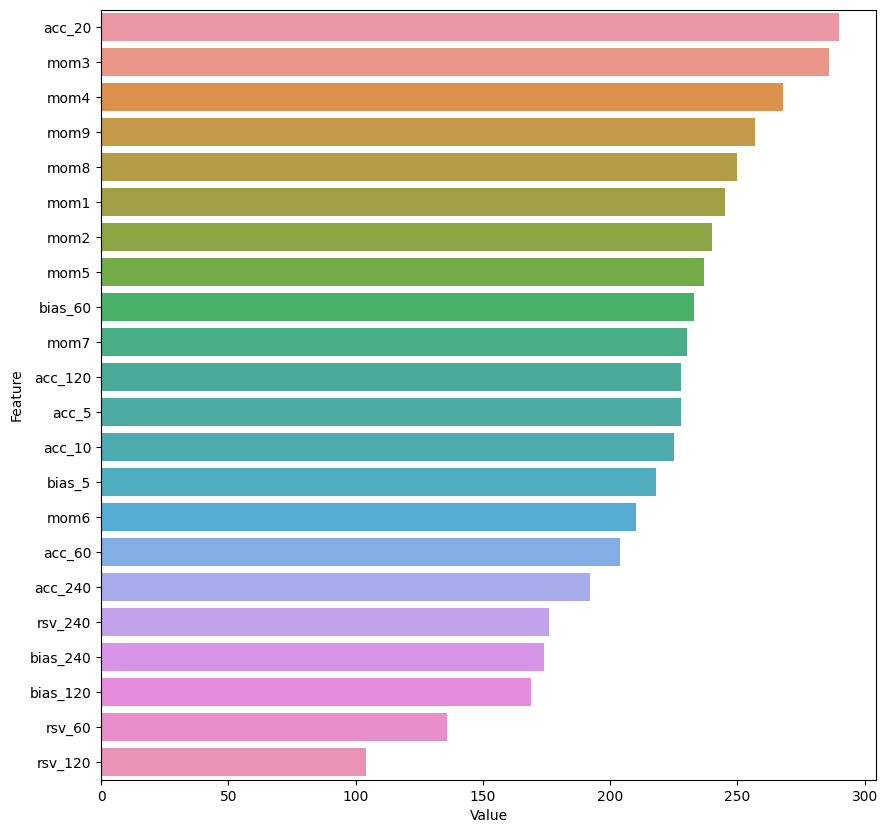

In [53]:
feature_imp = pd.DataFrame(zip(gs_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### 3.xgboost Model

In [54]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

cf_xgb = xgb.XGBRegressor()
cf_xgb.fit(*train)
cf_xgb.score(*test)

-0.008489463555824805

In [55]:
import xgboost as xgb
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.model_selection import RandomizedSearchCV

reg = xgb.XGBRegressor()
param_grid = {
    #'silent': [False],
    'max_depth': [6, 10, 15, 20],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
    'n_estimators': [100]
}
fit_params = {
    'early_stopping_rounds': 10,
    'eval_set': [(test[0], test[1])],
    'verbose': False,
    'eval_metric': 'rmse'
    
}
rs = RandomizedSearchCV(reg, param_grid, n_iter=20, n_jobs=1, verbose=2, cv=2, scoring='neg_mean_squared_error', refit=True, random_state=42)
rs.fit(train[0], train[1], **fit_params) #*train

Fitting 2 folds for each of 20 candidates, totalling 40 fits
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, subsample=0.7; total time=   1.6s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_depth=6, min_child_weight=5.0, n_estimators=100, reg_lambda=50.0, subsample=0.7; total time=   1.6s
[CV] END colsample_bylevel=0.9, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1.0, n_estimators=100, reg_lambda=1.0, subsample=0.6; total time=  17.2s
[CV] END colsample_bylevel=0.9, colsample_bytree=0.7, gamma=1.0, learning_rate=0.01, max_depth=20, min_child_weight=1.0, n_estimators=100, reg_lambda=1.0, subsample=0.6; total time=  17.0s
[CV] END colsample_bylevel=0.5, colsample_bytree=0.4, gamma=0.5, learning_rate=0.1, max_depth=15, min_child_weight=7.0, n_estimators=100, reg_lambda=50.0, subsample=0.9; total time=   1.8

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n...
                                                              1.0],
                                        'colsample_bytree': [0.4, 0.5, 0.6, 0.7,
                                         

In [56]:
rs.best_params_

{'subsample': 0.9,
 'reg_lambda': 50.0,
 'n_estimators': 100,
 'min_child_weight': 7.0,
 'max_depth': 15,
 'learning_rate': 0.1,
 'gamma': 0.5,
 'colsample_bytree': 0.4,
 'colsample_bylevel': 0.5}

In [57]:
xgb_best_params = rs.best_params_
print("Best Parameters:", xgb_best_params)
print("----------------")
xgb_best_model = xgb.XGBRegressor(**best_params )
xgb_best_model.fit(*train)

Best Parameters: {'subsample': 0.9, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.5}
----------------
[15:03:27] WARNING: ../src/learner.cc:541: 
Parameters: { min_child_samples, num_leaves } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8705914792749987, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_samples=112, min_child_weight=100.0, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_leaves=49, num_parallel_tree=1, random_state=0, reg_alpha=10,
             reg_lambda=0, scale_pos_weight=1, subsample=0.29073339724875163,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### 結果

In [58]:
xgb_best_model.score(*test)

-0.010434797292031117

<AxesSubplot:xlabel='Value', ylabel='Feature'>

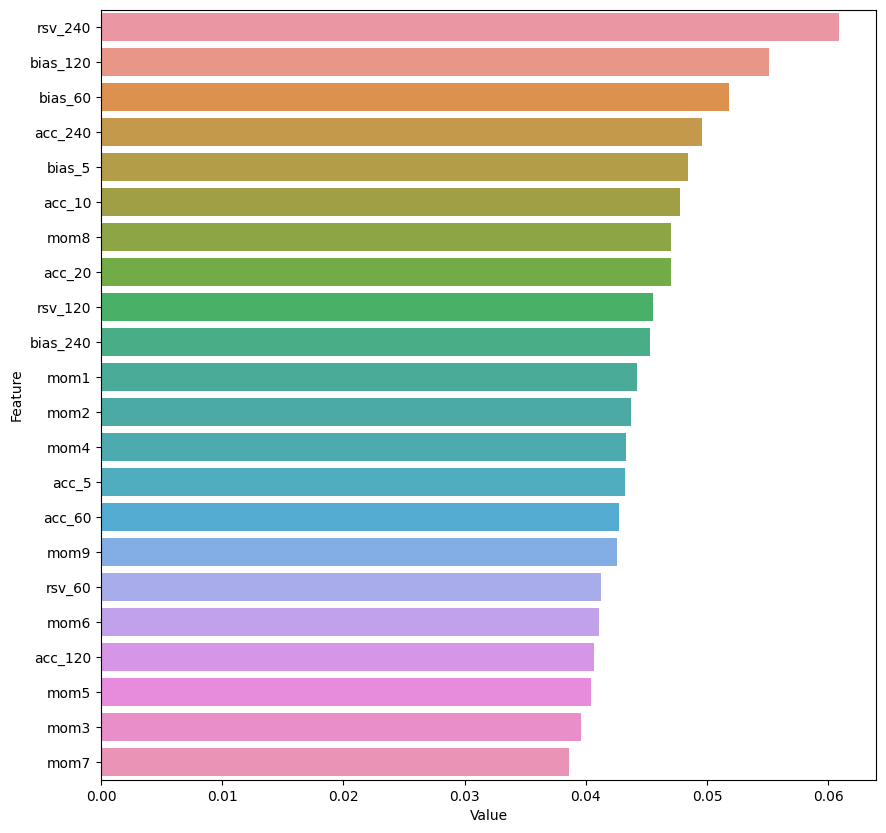

In [59]:
feature_imp = pd.DataFrame(zip(xgb_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
plt.figure(figsize=(10,10))
sns.barplot(x="Value", y="Feature", data=feature_imp)

### 4.Random Forest Model

In [60]:
#from sklearn.ensemble import RandomForestRegressor
#
#cf2 = RandomForestRegressor(n_estimators=100)
#cf2.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

In [61]:
from sklearn.ensemble import RandomForestRegressor

cf_rf = RandomForestRegressor(n_estimators=100)
cf_rf.fit(*train)
cf_rf.score(*test)

-0.0027760405732155657

<AxesSubplot:xlabel='Value', ylabel='Feature'>

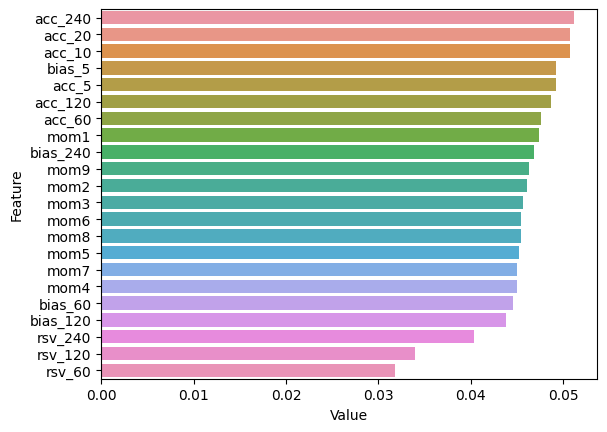

In [63]:
feature_imp = pd.DataFrame(zip(cf_rf.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

In [64]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()
# 参数取值范围
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 8], 
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 随机搜索
rs = RandomizedSearchCV(rf,
                        param_grid,
                        n_iter=10,
                        cv=5,
                        n_jobs=-1,
                        random_state=42)

rf.fit(*train)
rf.score(*test)

# 拟合模型
rs.fit(*train)

# 输出最佳参数
print('最佳参数:', rs.best_params_)

最佳参数: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': None, 'bootstrap': True}


In [65]:
rf_best_params = rs.best_params_

rf_best_model = RandomForestRegressor(**rf_best_params )
rf_best_model.fit(*train)

RandomForestRegressor(max_features='log2', min_samples_leaf=8)

In [66]:
rf_best_model.score(*test)

0.010646261022189019

<AxesSubplot:xlabel='Value', ylabel='Feature'>

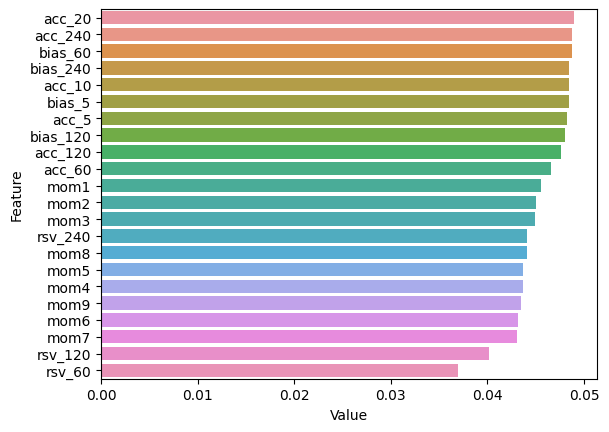

In [67]:
feature_imp = pd.DataFrame(zip(rf_best_model.feature_importances_, feature_names), 
                           columns=['Value','Feature']).sort_values('Value', ascending=False)
feature_imp

%matplotlib inline
import seaborn as sns
sns.barplot(x="Value", y="Feature", data=feature_imp)

In [68]:
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import RandomizedSearchCV
#
## 建立隨機森林回歸模型
#cf2 = RandomForestRegressor()
#
## 定義超參數範圍
#param_dist = {
#    'n_estimators': [50, 100, 200, 300],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth': [None, 10, 20, 30],
#    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False]
#}
#
## 執行隨機參數搜尋
#rs = RandomizedSearchCV(cf2, param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42)
#rs.fit(dataset_train[feature_names].astype(float), dataset_train['rank'])

在以上程式碼中，我們建立了 RandomForestRegressor 模型，
並定義了超參數的範圍。使用 RandomizedSearchCV 進行參數搜尋，
設定了迭代次數為 100，交叉驗證次數為 5，並設定了 random_state 來保持結果的可重現性。
透過這樣的方式，您可以進一步優化 RandomForestRegressor 模型，以提高其性能。

In [69]:
#feature_imp = pd.DataFrame(zip(cf2.feature_importances_, feature_names), 
#                           columns=['Value','Feature']).sort_values('Value', ascending=False)
#feature_imp
#
#%matplotlib inline
#import seaborn as sns
#plt.figure(figsize=(10,10))
#sns.barplot(x="Value", y="Feature", data=feature_imp)

### Ensemble learning

In [70]:
dataset_drop = dataset.dropna(subset=feature_names+['return'])

vals = model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result1'] = pd.Series(vals.swapaxes(0,1)[0], dataset_drop.index)

vals = gs_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result2'] = pd.Series(vals, dataset_drop.index)

vals = xgb_best_model.predict(dataset_drop[feature_names].astype(float))
dataset_drop['result3'] = pd.Series(vals, dataset_drop.index)

#vals = rf_best_model.predict(dataset_drop[feature_names].astype(float))
#dataset_drop['result4'] = pd.Series(vals, dataset_drop.index)

dataset_drop = dataset_drop.reset_index().set_index("date")

In [71]:
print(model.predict(dataset_drop[feature_names].astype(float)))
print(gs.predict(dataset_drop[feature_names].astype(float)))
print(rs.predict(dataset_drop[feature_names].astype(float)))
print(rf.predict(dataset_drop[feature_names].astype(float)))

[[0.40024057]
 [0.4706121 ]
 [0.49468625]
 ...
 [0.4527113 ]
 [0.49616477]
 [0.47630632]]
[0.45526392 0.49469257 0.46612155 ... 0.46323307 0.50854401 0.51095269]
[0.45878896 0.48727285 0.51112009 ... 0.42753578 0.49501957 0.48601879]
[0.44965405 0.53691088 0.42353638 ... 0.46842041 0.58051496 0.53349603]


# backtest

100%|██████████████████████████████████████████████████████████████████████████████| 174/174 [00:06<00:00, 27.99it/s]


<AxesSubplot:xlabel='date'>

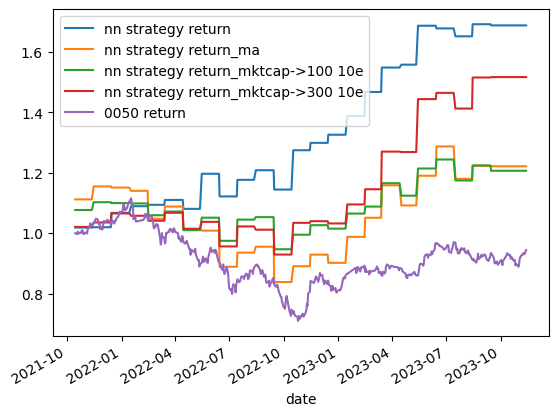

In [89]:
import math
from tqdm import tqdm

dates = sorted(list(set(dataset_drop.index)))
fil_ma_s = 1000  # start
fil_ma_e = 3000  # end

rs_1 = []
rs_2 = []
rs_3 = []  
rs_4 = []  
rs_5 = []  # 收益数据列表

for d in tqdm(dates):
    dataset_time = dataset_drop.loc[d]
    dataset_time = drop_extreme_case(dataset_time, feature_names, thresh=0.01)
    predi_target_0 = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3'] #+ dataset_time['result4']
    predi_target_1 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_s) & (dataset_time['vol_ma5'] < fil_ma_e) & (dataset_time['市值'] < 1e10), 0)
    predi_target_2 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_s) & (dataset_time['市值'] < 1e9), 0)
    predi_target_3 = predi_target_0.where((dataset_time['vol_ma5'] < fil_ma_e) & (dataset_time['市值'] < 1e10), 0)
    predi_target_4 = predi_target_0.where((dataset_time['vol_ma5'] > fil_ma_e) & (dataset_time['市值'] > 1e9), 0)
    
        

    condition_0 = (predi_target_0 >= predi_target_0.nlargest(20).iloc[-1])
    condition_1 = (predi_target_1 >= predi_target_1.nlargest(20).iloc[-1])
    condition_2 = (predi_target_2 >= predi_target_2.nlargest(20).iloc[-1])
    condition_3 = (predi_target_3 >= predi_target_3.nlargest(20).iloc[-1])
    condition_4 = (predi_target_4 >= predi_target_4.nlargest(20).iloc[-1])

    
    r0 = dataset_time['return'][condition_0].mean()
    r1 = dataset_time['return'][condition_1].mean()
    r2 = dataset_time['return'][condition_2].mean()
    r3 = dataset_time['return'][condition_3].mean()
    r4 = dataset_time['return'][condition_4].mean()

    
    rs_1.append(r0 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_2.append(r1 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_3.append(r2 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_4.append(r3 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    rs_5.append(r4 * (1 - 3 / 1000 - 1.425 / 1000 * 2 * 0.6))
    

rs_1 = pd.Series(rs_1, index=dates)[Aft:].cumprod()
rs_2 = pd.Series(rs_2, index=dates)[Aft:].cumprod()
rs_3 = pd.Series(rs_3, index=dates)[Aft:].cumprod()
rs_4 = pd.Series(rs_4, index=dates)[Aft:].cumprod()
rs_5 = pd.Series(rs_5, index=dates)[Aft:].cumprod()

s0050 = close['0050'][Aft:]

pd.DataFrame(
    {
        'nn strategy return': rs_1.reindex(s0050.index, method='ffill'),
        'nn strategy return_ma': rs_2.reindex(s0050.index, method='ffill'),
        'nn strategy return_mktcap->100 10e': rs_3.reindex(s0050.index, method='ffill'),
        #'nn strategy return_mktcap-<300 10e': rs_4.reindex(s0050.index, method='ffill'),
        'nn strategy return_mktcap->300 10e': rs_5.reindex(s0050.index, method='ffill'),
        '0050 return': s0050 / s0050[0],
    }
).plot()


In [87]:
result_col = ['result1','result2','result3','result4']
t1 = dataset_time[result_col]

In [90]:
corr_matrix = t1.corr()
corr_matrix

,result1,result2,result3,result4
result1,1.000000,0.619623,0.494481,0.582837
result2,0.619623,1.000000,0.701586,0.818266
result3,0.494481,0.701586,1.000000,0.622966
result4,0.582837,0.818266,0.622966,1.000000


In [74]:
predi_target = dataset_time['result1'] + dataset_time['result2'] + dataset_time['result3']
predi_target

date
2023-09-15    1.566395
2023-09-15    1.581522
2023-09-15    1.424432
2023-09-15    1.475061
2023-09-15    1.520221
                ...   
2023-09-15    1.674851
2023-09-15    1.278810
2023-09-15    1.371253
2023-09-15    1.402516
2023-09-15    1.484530
Length: 1281, dtype: float64

### 當月持股狀況

In [75]:
dataset.index.levels[1].max()

Timestamp('2023-11-15 00:00:00')

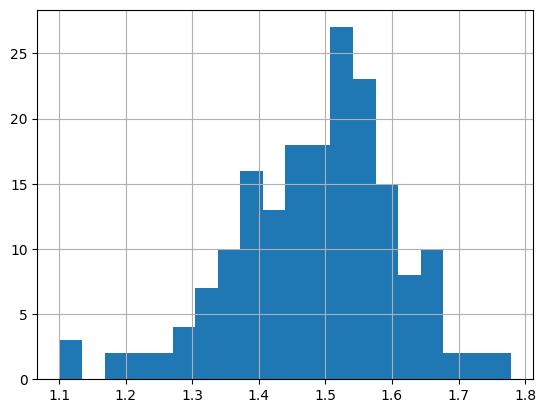

In [76]:
# get the latest dataset
last_date = dataset.index.levels[1].max()#"2022-10-15"
is_last_date = dataset.index.get_level_values('date') == last_date
last_dataset = dataset[is_last_date].copy()


last_dataset = drop_extreme_case(last_dataset,
                                 feature_names, thresh=0.01)


# remove NaN testcases
last_dataset = last_dataset.dropna(subset=feature_names)

# predict

vals = model.predict(last_dataset[feature_names].astype(float))
last_dataset['result1'] = pd.Series(vals.swapaxes(0,1)[0], last_dataset.index)

vals = gs_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result2'] = pd.Series(vals, last_dataset.index)

vals = xgb_best_model.predict(last_dataset[feature_names].astype(float))
last_dataset['result3'] = pd.Series(vals, last_dataset.index)

# calculate score

rank = last_dataset['result1'] + last_dataset['result2'] + last_dataset['result3']
#rank_target = rank.where((last_dataset['vol_ma5'] > fil_ma_s)  & (last_dataset['vol_ma5'] < fil_ma_e)  & (last_dataset['市值'] < 1e10), 0)
rank_target = rank.where((last_dataset['vol_ma5'] > fil_ma_e) )# & (last_dataset['市值'] < 1e10), 0)

condition = (rank_target >= rank_target.nlargest(20).iloc[-1]) 

# plot rank distribution
rank_target[rank_target != 0].hist(bins=20)


# show the best 20 stocks
slist1 = rank_target[rank_target != 0].reset_index()['stock_id']

In [77]:
last_dataset

,,mom1,mom2,mom3,mom4,mom5,mom6,mom7,mom8,mom9,bias_5,...,rsv_60,rsv_120,rsv_240,vol_ma5,市值,return,rank,result1,result2,result3
stock_id,date,,,,,,,,,,,,,,,,,,,,,
1101,2023-11-15,0.931312,1.047573,1.015580,0.918719,1.054502,0.775774,1.605565,0.997385,0.582099,1.000000,...,0.321429,0.196425,0.170700,26108.78850,7.531098e+11,NaN,NaN,0.488209,0.540832,0.495976
1102,2023-11-15,1.034324,0.952830,1.017837,0.921617,1.009714,0.879294,1.306309,1.296343,0.577242,1.003464,...,0.918919,0.546512,0.546512,5008.49190,4.671410e+11,NaN,NaN,0.514134,0.563820,0.549327
1103,2023-11-15,0.975146,0.896059,0.961758,1.217018,1.034162,0.884147,1.180455,1.103720,0.836309,1.001091,...,0.305556,0.114956,0.331608,189.96350,2.725732e+10,NaN,NaN,0.489627,0.531426,0.492867
1104,2023-11-15,1.002260,0.968538,1.054584,0.900513,1.041817,0.871040,1.250067,1.172781,0.695641,1.011278,...,0.434211,0.362637,0.718153,658.63635,4.632666e+10,NaN,NaN,0.502788,0.532941,0.530348
1108,2023-11-15,0.939015,0.975693,0.995896,0.917174,1.219080,0.908584,1.205342,1.226676,0.704955,1.026723,...,0.571429,0.270895,0.585799,526.86110,1.001012e+10,NaN,NaN,0.504922,0.491892,0.500655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9950,2023-11-15,1.037888,1.063320,0.978224,0.894659,1.193539,1.202384,1.076686,0.731279,0.927715,0.932681,...,0.710938,0.773006,0.794444,4808.53215,7.633962e+09,NaN,NaN,0.462973,0.487485,0.505817
9951,2023-11-15,1.014214,1.207436,0.891870,1.065317,1.121652,0.808777,1.085135,1.114727,0.727585,1.024112,...,0.548780,0.699814,0.840823,117.21700,1.304559e+10,NaN,NaN,0.503960,0.543514,0.569085
9955,2023-11-15,1.084517,0.908945,1.419451,0.350711,1.931229,0.992948,1.126728,1.009254,0.991785,0.983953,...,0.330986,0.330986,0.456522,3911.97270,3.059876e+09,NaN,NaN,0.498481,0.454251,0.444935


# 平均分配資產於股票之中

In [78]:
close = data.get("收盤價")

money = 321579
stock_prices = close[rank_target[condition].reset_index()['stock_id']].iloc[-1]


print("股票平分張數:")
money / len(stock_prices) / stock_prices / 1000


股票平分張數:


stock_id
1102    0.396522
2105    0.352222
2233    0.120442
2313    0.272063
2357    0.044664
2371    0.441123
2385    0.107552
2455    0.103735
2492    0.132337
2885    0.643158
2886    0.417635
2890    0.869132
3322    0.661685
3711    0.131257
4904    0.204048
4906    0.490960
5258    0.109010
6257    0.265768
6284    0.217283
6290    0.255221
Name: 2023-11-13 00:00:00, dtype: float64

In [79]:
T_stock = '1101'
(last_dataset['vol_ma5'][T_stock] > fil_ma_s)
(last_dataset['vol_ma5'][T_stock] < fil_ma_e)  & (last_dataset['市值'] < 1e10)

stock_id  date      
1101      2023-11-15    False
1102      2023-11-15    False
1103      2023-11-15    False
1104      2023-11-15    False
1108      2023-11-15    False
                        ...  
9950      2023-11-15    False
9951      2023-11-15    False
9955      2023-11-15    False
9960      2023-11-15    False
9962      2023-11-15    False
Length: 1341, dtype: bool

In [80]:
import pyfolio as pf

import pickle
pickle.dump(rs_2, open('230618_return_history.pkl', 'wb'))

In [81]:
 rs_2

2021-10-15    1.106509
2021-11-15    1.161650
2021-12-15    1.165972
2022-01-15    1.166073
2022-02-15    1.083135
2022-03-15    1.116107
2022-04-15    1.043721
2022-05-15    1.035763
2022-06-15    0.920864
2022-07-15    0.983744
2022-08-15    1.033774
2022-09-15    0.893323
2022-10-15    0.950262
2022-11-15    1.000613
2022-12-15    0.970174
2023-01-15    1.060858
2023-02-15    1.127619
2023-03-15    1.233735
2023-04-15    1.155111
2023-05-15    1.252538
2023-06-15    1.367429
2023-07-15    1.278558
2023-08-15    1.310524
2023-09-15    1.307863
dtype: float64

In [82]:
pf.tears.create_capacity_tear_sheet(rs_2)

TypeError: create_capacity_tear_sheet() missing 3 required positional arguments: 'positions', 'transactions', and 'market_data'

In [ ]:
import pickle
import pandas as pd

# 得到 上面的 回測結果
ret = pickle.load(open("230618_return_history.pkl", "rb"))

# 將回測報酬率取出來
ret = ret.pct_change().dropna()
#ret.index = pd.to_datetime(ret.index).tz_localize('Asia/Taipei')

# 利用pyfolio 比較報酬率

pf.create_returns_tear_sheet(ret, benchmark_rets=close['0050'].reindex(ret.index, method='ffill').pct_change())

###################################################################################################
## 移動窗格最佳化
[有空來試試看連結](https://hahow.in/courses/5b9d3a6dca498a001e917383/discussions/61b4c90147843d0006cf2593)

###################################################################################################

In [ ]:
train = dataset_train[feature_names].astype(float) , dataset_train['return'] #> 1.00
test = dataset_test[feature_names].astype(float) , dataset_test['return'] #> 1.00

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# 創建Random Forest模型
random_forest = RandomForestRegressor(n_estimators=100)

# 使用訓練資料訓練模型
random_forest.fit(*train)

# 使用測試資料評估模型
accuracy = random_forest.score(*test)
print("Random Forest 模型的準確率：", accuracy)

In [ ]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

import numpy as np

%matplotlib inline

def select(df):

    rank = df['pre']

    condition1 = (rank >= rank.nlargest(1).iloc[-1])

    return df['return'][condition1].mean() * (1-3/1000-1.425/1000*2*0.6)

end = 5

cf = lgb.LGBMRegressor(n_estimators=500)



train_time = ['2015','2016','2017','2018','2019']

s_time = ['2007','2008','2009','2010','2011']

test_time = ['2016','2017','2018','2019','2020']

dataset_copy = dataset_dropna.copy()

store_mse = []

In [ ]:
for time in range(end):

    print('%d 次執行中'%(time+1))

    dataset_dropna2_train = dataset_copy.loc[s_time[time]:train_time[time]] #2007~ 2015   2008~2016   2009~2017  2010~2018  ....

    dataset_dropna2_test = dataset_copy.loc[test_time[time]:test_time[time]]#            2016                2017               2018              2019  .....

    
    cf.fit(dataset_dropna2_train[feature_names].astype(float), dataset_dropna2_train['rank'])
    predict = cf.predict(dataset_dropna2_test[feature_names])

    dataset_dropna2_test['pre'] = predict

    dates = dataset_dropna2_test.index.get_level_values('date')
    
    b = dataset_dropna2_test.groupby(dates).apply(select).cumprod()
    
    s0050 = close['0050'][test_time[time]:test_time[time]]
    
    s0056 = close['0056'][test_time[time]:test_time[time]]
    
    pd.DataFrame({'Best 1 stocks return(include handling fee)':b.reindex(s0050.index, method='ffill'), 
    
                  '0050':s0050/s0050[0],'0056':s0056/s0056[0]}).plot()
    
    plt.ylabel('return')



In [ ]:
cf.predict(dataset_dropna2_test[feature_names])

In [ ]:
dataset_dropna2_train[feature_names].astype(float)